In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import string
from sklearn.preprocessing import LabelEncoder as le, OrdinalEncoder as oe, StandardScaler as ss, MinMaxScaler as mms, OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from xgboost import plot_tree

In [2]:
#path = f'/content/drive/MyDrive/Colab Notebooks/hackathons/AnalyticsOlympiad2022Data/data/'
path = 'data/'

In [3]:
train = pd.read_csv(path+'train.csv')

In [4]:
train.head()

,ID,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME,TYPE_OF_VEHICLE
0,816393,40-64,female,20-29y,university,middle class,0.638050,0.0,after 2015,0.0,0.0,37379,11000.0,0,0,0,0.0,Sports Car
1,251762,26-39,male,20-29y,high school,middle class,0.475741,1.0,before 2015,1.0,0.0,10238,9000.0,0,0,0,1.0,HatchBack
2,481952,40-64,male,20-29y,none,middle class,0.839817,1.0,before 2015,1.0,1.0,10238,12000.0,0,0,0,1.0,Sedan
3,3506,40-64,male,20-29y,high school,upper class,0.682527,1.0,before 2015,0.0,1.0,92099,6000.0,1,0,0,1.0,Sedan
4,498013,40-64,female,20-29y,none,working class,0.572184,1.0,after 2015,1.0,1.0,32122,15000.0,0,0,1,0.0,Sedan


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105000 entries, 0 to 104999
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   105000 non-null  int64  
 1   AGE                  105000 non-null  object 
 2   GENDER               105000 non-null  object 
 3   DRIVING_EXPERIENCE   105000 non-null  object 
 4   EDUCATION            105000 non-null  object 
 5   INCOME               105000 non-null  object 
 6   CREDIT_SCORE         105000 non-null  float64
 7   VEHICLE_OWNERSHIP    105000 non-null  float64
 8   VEHICLE_YEAR         105000 non-null  object 
 9   MARRIED              105000 non-null  float64
 10  CHILDREN             105000 non-null  float64
 11  POSTAL_CODE          105000 non-null  int64  
 12  ANNUAL_MILEAGE       105000 non-null  float64
 13  SPEEDING_VIOLATIONS  105000 non-null  int64  
 14  DUIS                 105000 non-null  int64  
 15  PAST_ACCIDENTS   

In [6]:
train['ID'].duplicated().sum()

6515

In [7]:
train.columns = [x.lower() for x in list(train.columns)]

In [8]:
train['outcome'].value_counts()

0.0    60622
1.0    44378
Name: outcome, dtype: int64

In [9]:
train.isnull().sum()

id                     0
age                    0
gender                 0
driving_experience     0
education              0
income                 0
credit_score           0
vehicle_ownership      0
vehicle_year           0
married                0
children               0
postal_code            0
annual_mileage         0
speeding_violations    0
duis                   0
past_accidents         0
outcome                0
type_of_vehicle        0
dtype: int64

In [10]:
train.duplicated().sum()

0

#### Numerical columns:
- id
- credit_score
- vehicle_ownership
- married
- children
- postal_code
- annual_mileage
- speeding_violations
- duis
- past_accidents
- outcome

#### Categorical columns:
- age
- gender
- driving_experience
- education
- income
- vehicle_year
- type_of_vehicle

### No duplicates and Null values

In [11]:
def check_value_cnts(var):
    print('------------------------------------------------------------------------')
    print(train[var].value_counts())

In [12]:
nums = list(train.select_dtypes(include='number').columns)
cats = list(train.select_dtypes(include='object').columns)

In [13]:
list(map(check_value_cnts, cats))

------------------------------------------------------------------------
40-64    33716
65+      32962
26-39    20018
16-25    18304
Name: age, dtype: int64
------------------------------------------------------------------------
male      65317
female    39683
Name: gender, dtype: int64
------------------------------------------------------------------------
20-29y    37493
0-9y      33111
10-19y    25101
30y+       9295
Name: driving_experience, dtype: int64
------------------------------------------------------------------------
high school    46590
university     31220
none           27190
Name: education, dtype: int64
------------------------------------------------------------------------
upper class      51271
working class    24454
middle class     14738
poverty          14537
Name: income, dtype: int64
------------------------------------------------------------------------
before 2015    57511
after 2015     47489
Name: vehicle_year, dtype: int64
-----------------------------

[None, None, None, None, None, None, None]

### Feature transformation and encoding

#### Features to be Label Encoded(Nominal):
- gender
- type_of_vehicle
- vehicle_year

#### Features to be Ordinal Encoded(Ordinal):
- age
- driving_experience
- education
- income

In [14]:
y = train['outcome']
X = train.drop('outcome', axis = 1)

In [15]:
X.drop(['id', 'postal_code'], axis = 1, inplace = True)

In [16]:
nums = X.select_dtypes(include='number').columns
ohei = ['gender','type_of_vehicle', 'vehicle_year']
ordi = ['age','driving_experience','education','income']

In [17]:
agec = ['16-25','26-39','40-64','65+']
dexp = ['0-9y','10-19y','20-29y','30y+']
educ = ['none','high school','university']
inco = ['poverty','working class','middle class','upper class']

In [18]:
cat_pipeline = Pipeline(
    steps=[
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False))
    ]
)

ord_pipeline = Pipeline(
    steps=[
        ("ord", oe(categories = [agec, dexp, educ, inco])),
        ("scaler", ss())
    ]
)

num_pipeline = Pipeline(
    steps=[
        ("scaler", ss())
    ]
)

In [19]:
transform = ColumnTransformer(
    transformers=[
        ("nums", num_pipeline, nums),
        ("cats", cat_pipeline, ohei),
        ("ords", ord_pipeline, ordi)
    ]
)

In [20]:
X1 = transform.fit_transform(X)

In [21]:
transform.transformers_

[('nums',
  Pipeline(steps=[('scaler', StandardScaler())]),
  Index(['credit_score', 'vehicle_ownership', 'married', 'children',
         'annual_mileage', 'speeding_violations', 'duis', 'past_accidents'],
        dtype='object')),
 ('cats',
  Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))]),
  ['gender', 'type_of_vehicle', 'vehicle_year']),
 ('ords',
  Pipeline(steps=[('ord',
                   OrdinalEncoder(categories=[['16-25', '26-39', '40-64', '65+'],
                                              ['0-9y', '10-19y', '20-29y',
                                               '30y+'],
                                              ['none', 'high school',
                                               'university'],
                                              ['poverty', 'working class',
                                               'middle class', 'upper class']])),
                  ('scaler', StandardScaler())]),
  ['age', 'driving_experience', 'educ

In [22]:
X.duplicated().sum()

0

In [23]:
y.value_counts()/len(y)

0.0    0.577352
1.0    0.422648
Name: outcome, dtype: float64

***

In [24]:
col_names = list(nums)+['female',
                        'male',
                        'vehicle_hatchback',
                        'vehicle_suv',
                        'vehicle_sedan',
                        'vehicle_sports_car',
                        'vehicle_year_after_2015',
                        'vehicle_year_before_2015']+ordi

In [25]:
X1 = pd.DataFrame(X1, columns = col_names)

## Data Visualization

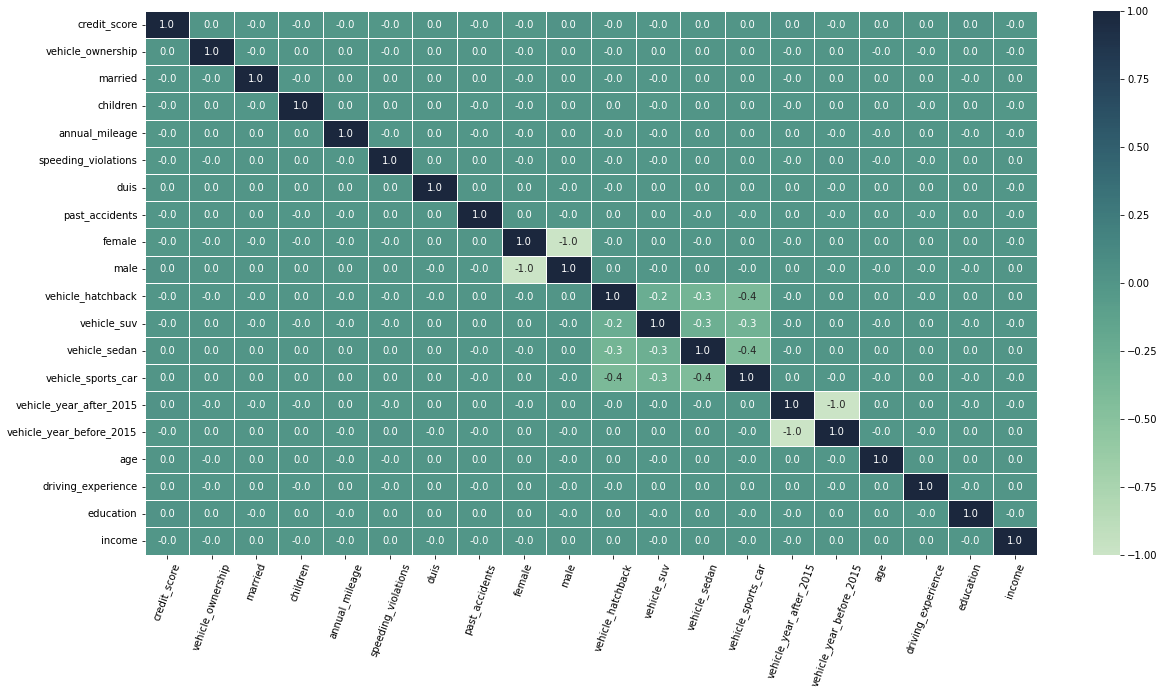

In [26]:
#### heatmap
plt.figure(figsize = (20,10))
ax = sns.heatmap(X1.corr(),cmap = sns.color_palette("ch:s=0,rot=-.45", as_cmap=True) ,annot = True, fmt = '.1f', linewidth = .5)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 70)
plt.show()

### Inference
- No correlation among the features
***

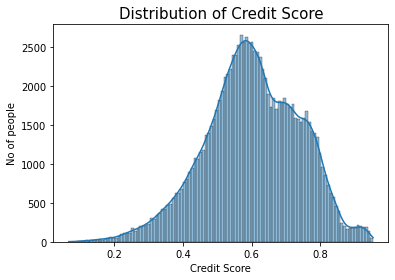

In [27]:
sns.histplot(x = X['credit_score'], kde = True)
plt.title('Distribution of Credit Score', fontsize = '15')
plt.xlabel('Credit Score')
plt.ylabel('No of people')
plt.show()

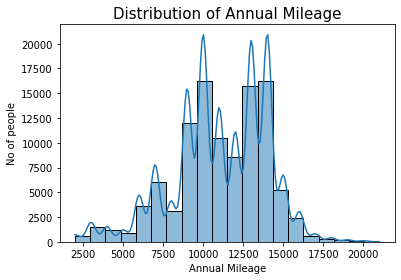

In [28]:
sns.histplot(x = X['annual_mileage'], kde = True, bins = 20)
plt.title('Distribution of Annual Mileage', fontsize = '15')
plt.xlabel('Annual Mileage')
plt.ylabel('No of people')
plt.show()

### Inference
- The Credit Score is Left skewed (Negatively Skewed)
- Most of the people have an annual mileage between 10k to 15k kms
***

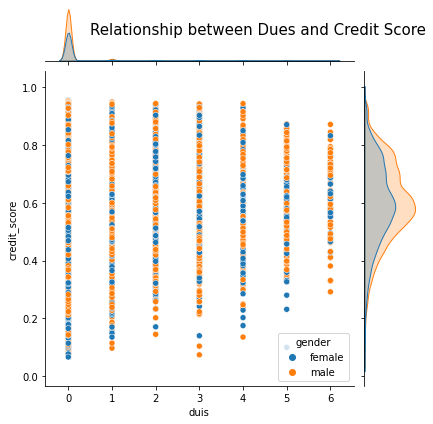

In [29]:
sns.jointplot(data = X, x= 'duis',y= 'credit_score', hue = 'gender')
plt.title('Relationship between Dues and Credit Score', fontsize = 15, x = -2, y = 1.1)
plt.show()

### Inference - 
- The number of males having 0 dues is more than that of females
- More number of males than females are having higher number of dues and a lower credit_score
***

In [30]:
age_cs = pd.pivot_table(data= X, values = ['credit_score'], columns = 'age',aggfunc = np.sum)

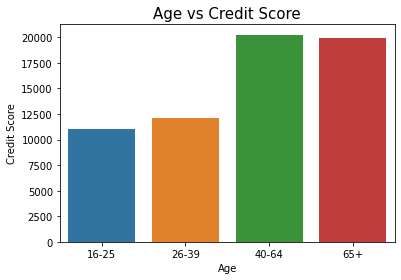

In [31]:
sns.barplot(x = age_cs.columns, y = age_cs.values[0])
plt.title('Age vs Credit Score', fontsize = 15)
plt.ylabel('Credit Score')
plt.xlabel('Age')
plt.show()

### Inference
- As the age increases, the credit_score increases
***

In [32]:
gs = pd.pivot_table(data=X, columns = 'gender', values = 'speeding_violations', aggfunc = np.count_nonzero)

In [33]:
gs

gender,female,male
speeding_violations,13429,22408


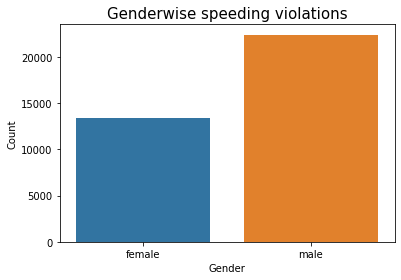

In [35]:
# male,female and speeding_violations
sns.barplot(x = gs.columns, y = gs.values[0])
plt.title('Genderwise speeding violations', fontsize = 15)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

### Inference
- More males have speeding violations than females
***

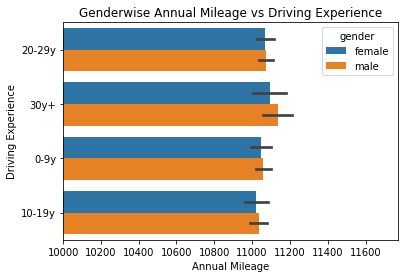

In [55]:
sns.barplot(data = X, y = 'driving_experience', x = 'annual_mileage', hue = 'gender', saturation = .8)
plt.xlim(10000)
plt.xlabel('Annual Mileage')
plt.ylabel('Driving Experience')
plt.title('Genderwise Annual Mileage vs Driving Experience')
plt.show()

## NOTE:
### THE SCALES OF THE GRAPH HAVE BEEN CHANGED TO VIEW THE MINUTE DIFFERENCES

### Inference
- Almost all the age groups have an average mileage of 11-11.2 kms
***

In [41]:
pd.pivot_table(data = X, index = ['vehicle_ownership', 'vehicle_year', 'income'])

annual_mileage  children  \
vehicle_ownership vehicle_year income                                    
0.0               after 2015   middle class     11115.826702  0.517241   
                               poverty          10912.888889  0.522667   
                               upper class      11022.037218  0.504652   
                               working class    11155.046826  0.509886   
                  before 2015  middle class     10926.510989  0.545330   
                               poverty          11018.315018  0.516484   
                               upper class      11028.994577  0.508552   
                               working class    11036.339755  0.517513   
1.0               after 2015   middle class     11035.754399  0.532946   
                               poverty          11122.730574  0.525781   
                               upper class      11080.646002  0.514301   
                               working class    11109.017643  0.528752   
                  before 2015  middle class     11002.349831  0.528271   
                               poverty          11077.687720  0.518428   
                               upper class      11036.296232  0.516510   
                               working class    11098.138442  0.526658   

                                              credit_score      duis  \
vehicle_ownership vehicle_year income                                  
0.0               after 2015   middle class       0.601110  0.126437   
                               poverty            0.609386  0.149333   
                               upper class        0.600985  0.114838   
                               working class      0.606341  0.118106   
                  before 2015  middle class       0.604773  0.121566   
                               poverty            0.599626  0.115751   
                               upper class        0.599713  0.139132   
                               working class      0.591726  0.121716   
1.0               after 2015   middle class       0.604841  0.137589   
                               poverty            0.600375  0.123094   
                               upper class        0.602959  0.134618   
                               working class      0.607867  0.142888   
                  before 2015  middle class       0.601589  0.134968   
                               poverty            0.599847  0.124790   
                               upper class        0.600371  0.122295   
                               working class      0.603484  0.131393   

                                               married  past_accidents  \
vehicle_ownership vehicle_year income                                    
0.0               after 2015   middle class   0.577365        0.557913   
                               poverty        0.599111        0.611556   
                               upper class    0.584476        0.527424   
                               working class  0.595734        0.518210   
                  before 2015  middle class   0.592033        0.549451   
                               poverty        0.604396        0.504029   
                               upper class    0.591364        0.557363   
                               working class  0.581436        0.553853   
1.0               after 2015   middle class   0.586672        0.535193   
                               poverty        0.585512        0.585512   
                               upper class    0.585517        0.551237   
                               working class  0.573840        0.547266   
                  before 2015  middle class   0.585402        0.556323   
                               poverty        0.584187        0.550390   
                               upper class    0.583585        0.551254   
                               working class  0.579704        0.534882   

                                              speeding_violations  
vehicle_ownersh

## Feature Selection

In [42]:
X1.shape

(105000, 20)

In [43]:
# 20 dimensional data

In [44]:
pca = PCA(.8)

In [45]:
fit_pca = pca.fit(X1)

In [46]:
fit_pca.explained_variance_ratio_

array([0.07503854, 0.07452225, 0.0741998 , 0.07362236, 0.07321692,
       0.07305323, 0.07278996, 0.07247858, 0.07234279, 0.072123  ,
       0.07169455])

In [47]:
# 11 dimensional data

In [48]:
X2 = pca.transform(X1)

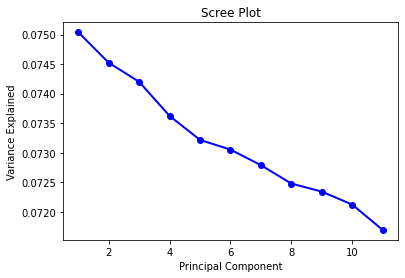

In [49]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

## Train Test Splitting

In [50]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X2,y,test_size = .1, stratify = y)

In [51]:
print(Xtrain.shape)
print(Xtest.shape)

(94500, 11)
(10500, 11)


## Modeling

In [52]:
def print_acc(model,Xtrain,Xtest,ytrain,ytest):
    print('------------------------------------------|')
    print(f'|  Training Accuracy | {log_loss(ytrain, model.predict(Xtrain))} |')
    print('------------------------------------------|')
    print(f'|  Test Accuracy     | {log_loss(ytest, model.predict(Xtest))} |')
    print('------------------------------------------|')

def gen_conf(actual,pred):
    classes = [0,1]
    cm = confusion_matrix(actual,pred, labels=classes)
    sn.heatmap(cm/np.sum(cm),fmt = '.2%', annot=True)
    plt.title("Confusion matrix")
    plt.show()

### Naive Bayes

In [53]:
gnb = BernoulliNB()
gnb.fit(Xtrain, ytrain)
pred = gnb.predict(Xtest)
print(log_loss(ytest, gnb.predict_proba(Xtest)))

0.6814010302513056


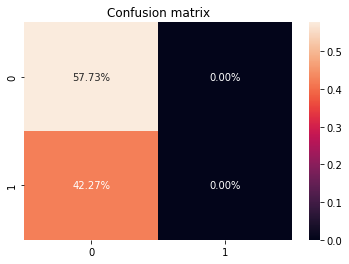

In [54]:
gen_conf(ytest, pred)

### From the basic Naive Bayes model we can see that the false negatives are high. The True negatives are very low and the False Positives are very low. 
### We must decrease the False Negatives.
***

### Random Forest Classifier

In [55]:
dtc = RandomForestClassifier(n_jobs = -1)
dtc.fit(Xtrain, ytrain)
dpred = dtc.predict(Xtest)
log_loss(ytest, dpred)

16.055720203028432

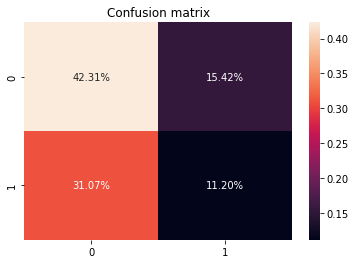

In [56]:
gen_conf(ytest, dpred)

***

### XGBoost with RandomizedSearchCV

In [57]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.02, 0.05]    
        }

In [62]:
skf = StratifiedKFold(n_splits = 10, shuffle = True)

In [63]:
xgc = xgb.XGBClassifier(learning_rate = 0.01, n_estimators = 100, objective = 'binary:logistic', nthread = 6, eval_metric = 'logloss')

In [64]:
random_cv = RandomizedSearchCV(xgc,param_distributions = params, n_jobs = -1, cv = skf.split(Xtrain,ytrain), n_iter = 50, scoring = 'neg_log_loss')

In [65]:
random_cv.fit(Xtrain, ytrain)

KeyboardInterrupt: 

In [ ]:
random_cv.best_params_

In [ ]:
random_cv.best_score_

In [ ]:
#random_cv.fit(Xtrain, ytrain)
pred_proba = random_cv.predict_proba(Xtrain)
preds = random_cv.predict(Xtrain)
print(log_loss(ytrain, pred_proba))

In [ ]:
test_preds = random_cv.predict_proba(Xtest)
print(log_loss(ytest, test_preds))

In [ ]:
test_pred = random_cv.predict(Xtest)

In [ ]:
gen_conf(ytest, test_pred)

In [ ]:
# this function adjusts the probability
def change_probas(pred_probas, p):
    x = []
    for i in pred_probas:
        if i[1] > p:
            x.append(i[1])
        else:
            x.append(i[0])
    return np.array(x)

def return_probas(pred_probas, p):
    x = []
    for i in pred_probas:
        if i[1] > p:
            x.append(1.0)
        else:
            x.append(0.0)
    return np.array(x)

In [ ]:
gen_conf(ytest, return_probas(test_preds, .454))

***